In [0]:
!pip install -q keras

In [0]:
import numpy as np
from numpy.random import *
import cv2
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! ls -l "/content/drive/My Drive/Colab Work/jcoin_1_5_10"

#  単独コインのクラス

In [0]:
class Jcoin:
    home_dir = "/content/drive/My Drive/Colab Work"
    dir = home_dir + '/jcoin_images'
    index = {}

    # 元画像ファイルを指定し、コインオブジェクトを生成
    def __init__(self, value, side, scale = 0.2):
        self.value = value
        self.side = side
        self.file_name = "{:0=3}yen_{}.png".format(value, side)
        tmp_img = cv2.imread(Jcoin.dir + '/' + self.file_name, 1)
        tmp_height, tmp_width, channels = tmp_img.shape[:3]
        self.img = cv2.resize(tmp_img, (int(tmp_height * scale), int(tmp_width * scale)))
        self.height, self.width, channels = self.img.shape[:3]
        self.radius = int(self.width / 2)
        Jcoin.index[(value, side)] = self ###

    def set_to_field(self, field, x_offset, y_offset, random_rotation=True):
        field_height, field_width, channels = field.shape[:3]

        if random_rotation:
            out_img = self.rotate(self.img, 360.0 * np.random.rand())

        cx, cy = self.width / 2, self.height / 2

        for iy in range(self.height):
            for ix in range(self.width):
                if random_rotation:
                    b, g, r = out_img[iy, ix]
                else:
                    b, g, r = self.img[iy, ix]
                #if [255, 0, 0] != [b, g, r] and 
                if np.linalg.norm(np.array([ix, iy]) - np.array([cx, cy])) < r:
                    x, y = x_offset + ix - self.radius, y_offset + iy - self.radius
                    if x < field_width and y < field_height:
                        if  [255,0,0] == [b, g, r]:
                            [b, g, r] = [0, 0, 0]
                        field[y, x] = [b, g, r]

    def rotate(self, in_img, degree):
        center = tuple(np.array([self.width / 2.0,  self.height / 2.0]))
        size = tuple(np.array([self.width, self.height]))
        rotation_matrix = cv2.getRotationMatrix2D(center, degree, 1.0)
        return cv2.warpAffine(in_img, rotation_matrix, size, flags=cv2.INTER_CUBIC)

#  コイン集合のクラス

In [0]:
class Jcoins:
    values = [1, 5, 10, 50, 100, 500] # Yens
    sides = ['F', 'B'] # Front, Back
    coins = {}

    # 最初に jcoins=Jcoins() でインスタンスを生成したときに呼ばれる。
    # 6価額(1円～500円)×両面＝12種類、のコインオブジェクトを生成し、辞書 coins に保有。
    def __init__(self):
        for val in Jcoins.values:
            for side in Jcoins.sides:
                Jcoins.coins[(val, side)] = Jcoin(val, side, 0.4)

    # 1種類のコインを返す。
    def index(self, idx):
        return Jcoins.coins[idx]

    # フィールド画像上で新しく投入しようとするコイン画像が、もともとあるコイン画像と重なるかどうか判定（True なら重ならない）
    def check_overlap(self, pos, positions, field_img):
        x, y, r = pos
        field_height, field_width, channels = field_img.shape[:3]

        if x - r < 0 or field_width < x + r or y - r < 0 or field_height < y + r :
            return False

        for p in positions:
            if  np.linalg.norm(np.array([pos[0],pos[1]]) - np.array([p[0],p[1]])) < r + p[2] :
                return False # Reject
        positions.append(pos)
        return True # Adopt

    # フィールド画像に num 個のコインをランダムに投入し、合計額を返す。
    def set_to_random_position_of_field(self, field_img, num, overlap):
        positions = []
        field_height, field_width, channels = field_img.shape[:3]
        total = 0
        count = {}
        for v in Jcoins.values:
            count[v] = 0

        for i in range(num):
            #val = Jcoins.values[randint(len(Jcoins.values))]
            r = randint(3)
            if 0 == r:
              val = 1
            elif 1 == r:
              val = 5
            else:
                val = 10
            side = 'F' if 0==randint(2) else 'B'
            coin = jcoins.index((val, side))
            x, y, r = randint(field_width), randint(field_height), coin.radius
            if (overlap) or self.check_overlap([x, y, r], positions, field_img):
                coin.set_to_field(field_img, x, y, random_rotation=True)
                total = total + coin.value
                count[coin.value] = count[coin.value] + 1
                
        return total, count




In [0]:
samples = 500
field_width, field_height = 300, 300
field_img = np.zeros((field_height, field_width, 3), np.uint8)

jcoins = Jcoins()
home_dir = "/content/drive/My Drive/Colab Work"
outdir = home_dir + "/jcoin_1_5_10"

# データ生成用ディレクトリの掃除
files = os.listdir(outdir)
for f in  files:
  pth = outdir + '/' + f
  os.remove(pth)

# データ生成（訓練用、評価用）
for i in range(samples):
    field_img[:] = [0, 0, 0] # G, B, R
    total, count = jcoins.set_to_random_position_of_field(field_img, int(randint(20) + 1), overlap=False)
    coins = 0
    for v in Jcoins.values:
        coins = coins + count[v]
    file_name = "#{:0=6}_{:0=4}yen_{:0=2}({:0=2}_{:0=2}_{:0=2}_{:0=2}_{:0=2}_{:0=2}).png".format(i, total, coins,count[1], count[5], count[10], count[50], count[100], count[500])
    # print(file_name)
    cv2.imwrite(outdir + '/' + file_name, field_img)


In [0]:
import subprocess
ret = subprocess.getoutput('ls -l')
print(ret)

In [8]:
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Flatten, Dropout
from keras.optimizers import SGD
import numpy as np
import cv2
import os
import time

Using TensorFlow backend.


データ読み込み

In [0]:
samples = 500
size = 50 # 50
img_rows, img_cols = size, size
depth = 3
dim = img_rows * img_cols * depth

home_dir = "/content/drive/My Drive/Colab Work"
dir = home_dir + "/jcoin_1_5_10"

files = os.listdir(dir)
x_train, y_train = [], []
x_test , y_test  = [], []

for i, f in enumerate(files):
    img = cv2.imread(dir + '/' + f, 1)
    #value = int(f[16:18]) # 全コインの個数
    value01 = int(f[20:21]) # 1円玉の個数
    value05 = int(f[23:24]) # 5円玉の個数
    value10 = int(f[26:27]) # 10円玉の個数
    value = int(f[8:12]) # 合計額
    img = cv2.resize(img, (size, size))
    height, width, channels = img.shape[:3]
    print(f, height, width, channels, value)
    x = img.reshape(img_rows, img_cols, 3).astype('float32') /255
    y = [value01, value05, value10]
    if i < int(samples * 0.9):
      x_train.append(x)
      y_train.append(y)
    else:
      x_test.append(x)
      y_test.append(y)
      
x_train, y_train = np.array(x_train), np.array(y_train)
x_test , y_test  = np.array(x_test) , np.array(y_test)

print(x_train.shape)

Epoch 1/1000
450/450 [==============================] - 2s 4ms/step - loss: 3.1556
Epoch 2/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8246
Epoch 3/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8146
Epoch 4/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.7972
Epoch 5/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.7975
Epoch 6/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8024
Epoch 7/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8044
Epoch 8/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.7973
Epoch 9/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.7969
Epoch 10/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.7969
Epoch 11/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8010
Epoch 12/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.8006
E

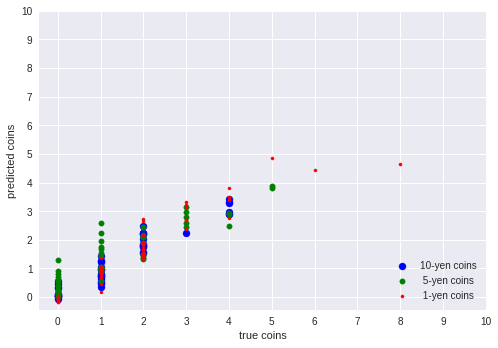

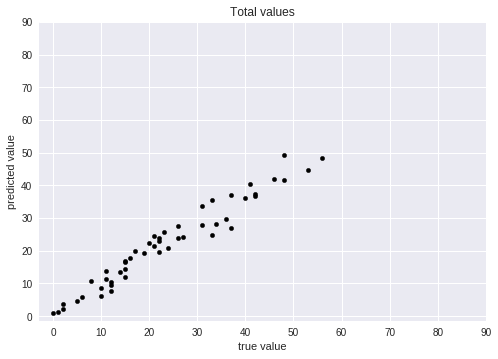

In [26]:
from keras.layers import Dense, Activation
model = keras.models.Sequential()

# neural network model parameters
hidden_units = 50 # 600
layer_depth = 1
act =  'sigmoid' 
bias = True
ep = 1000 # 00

model.add(Conv2D(size,3,input_shape=(size,size,3)))
model.add(Activation('relu'))
model.add(Conv2D(size,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(size*2,3, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(size*2,3))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(size*16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# first hidden layer
model.add(Dense(units = hidden_units, input_dim = dim, use_bias = bias))
model.add(Activation(act))

model.add(Dense(units = int(hidden_units / 2), use_bias = bias))
model.add(Activation(act))
model.add(Dense(units = int(hidden_units / 4), use_bias = bias))
model.add(Activation(act))
model.add(Dense(units = int(hidden_units / 8), use_bias = bias))
model.add(Activation(act))
##

# output layer
model.add(Dense(units = 3, use_bias = bias))
model.add(Activation('linear'))

# Note: Activation is not 'softmax' for the regression model.

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = 'mean_squared_error', optimizer = sgd)

start_fit = time.time()
model.fit(x_train, y_train, epochs = ep, verbose = 1)
elapsed = time.time() - start_fit
print("elapsed = {:.1f} sec".format(elapsed))

# predict
y_predict = model.predict(x_test)

def p1format(lst):
  return "({0:>5.0f}, {1:>5.2f})".format(lst[0], lst[1])

yp01, yp05, yp10, yp_total, yt01, yt05, yt10, yt_total = [], [], [], [], [], [], [], []
print("1-yen(true,predicted) 5-yen(same left) 10-yen(same left) Total val(same left)")
print("-" * 80)
for (yp, yt) in zip(y_predict, y_test):
  yp01.append(yp[0])
  yp05.append(yp[1])
  yp10.append(yp[2])
  predicted_total = yp[0] + yp[1] * 5 + yp[2] * 10
  yp_total.append(predicted_total)
  
  yt01.append(yt[0])
  yt05.append(yt[1])
  yt10.append(yt[2])
  true_total = yt[0] + yt[1] * 5 + yt[2] * 10
  yt_total.append(true_total)

  print(list(map(p1format, list(zip(yt, yp)))), end='')
  print(" ",p1format((true_total, round(predicted_total, 1))))
  
import matplotlib.pyplot as plt
plt.scatter(yt10, yp10, c='blue' , marker="o", s=50, label='10-yen coins')
plt.scatter(yt05, yp05, c='green', marker="o", s=30, label=' 5-yen coins')
plt.scatter(yt01, yp01, c='red'  , marker="o", s=10, label=' 1-yen coins')

plt.legend(loc='lower right')
plt.xlabel("true coins")
plt.ylabel("predicted coins")
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.show()

plt.scatter(yt_total, yp_total, c='black', marker="o", s=20)
#predicted_graph(plt, yt_total, yp_total, 'black', 'Total values', 'yens') 
plt.title('Total values')
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.xticks( np.arange(0, 100, 10) )
plt.yticks( np.arange(0, 100, 10) )

plt.show()
